In [51]:
# Load core libraries for data wrangling, plotting, and basic modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

Collect and preprocessing the data

In [52]:
# Read the GEFCOM dataset with hourly market info and named columns
gefcom = pd.read_csv(
    'Data/GEFCOM.txt',
    sep=r"\s+",
    names=['Date', 'Hour', 'Price', 'System_load', 'Zonal_load', 'Day_of_week'],
)

In [53]:
# Inspect column data types to confirm how pandas parsed the raw file
gefcom.dtypes


Date           float64
Hour           float64
Price          float64
System_load    float64
Zonal_load     float64
Day_of_week    float64
dtype: object

In [54]:
# Convert Date from YYYYMMDD integers to pandas datetime objects
gefcom['Date'] = pd.to_datetime(gefcom['Date'], format='%Y%m%d')

In [55]:
# Quick numeric summary to spot the basic scale and outliers
gefcom.describe()

,Date,Hour,Price,System_load,Zonal_load,Day_of_week
count,25968,25968.00000,25968.000000,25968.000000,25968.000000,25968.000000
mean,2012-06-24 12:00:00,11.50000,48.190072,18165.881200,6105.779767,4.000000
min,2011-01-01 00:00:00,0.00000,12.520000,11544.000000,3395.000000,1.000000
25%,2011-09-28 00:00:00,5.75000,33.470000,15620.000000,5131.000000,2.000000
50%,2012-06-24 12:00:00,11.50000,42.870000,18069.000000,6076.000000,4.000000
75%,2013-03-22 00:00:00,17.25000,54.300000,19858.250000,6714.000000,6.000000
max,2013-12-17 00:00:00,23.00000,363.800000,33449.000000,11441.000000,7.000000
std,NaN,6.92232,26.179381,3453.664269,1309.476852,2.002348


In [56]:
# Check how many missing values each column has
gefcom.isna().sum()

Date           0
Hour           0
Price          0
System_load    0
Zonal_load     0
Day_of_week    0
dtype: int64

In [57]:
# Verify whether any duplicate rows are present
gefcom.duplicated().sum()

np.int64(0)

In [60]:
# Create a log-price column for more stable modeling and keep a copy for plotting
gefcom['Log_price'] = np.log(gefcom['Price'])

# Model building

- ARX: 
$$p_{d,h} = \beta_{0} + \beta_{1p_{d-1,h}} + \beta_{2p_{d-2,h}} + \beta_{3p_{d-7,h}} + \beta_{4p_{min,d-1}} + \beta_{5z_{d}} + \sum \beta_{D} D_{d} + \epsilon_{d,h}$$

In [ ]:
# Build time-based features (price lags, day index, previous-day min) and weekday dummies
# Lags of log price
gefcom["p_lag1"] = gefcom["Log_price"].shift(24)    # p_{d-1,h}
gefcom["p_lag2"] = gefcom["Log_price"].shift(48)    # p_{d-2,h}
gefcom["p_lag7"] = gefcom["Log_price"].shift(168)   # p_{d-7,h}

# Daily minimum log price (previous day)
daily_min = gefcom.groupby("Date")["Log_price"].min().shift(1)
gefcom = gefcom.merge(daily_min.rename("min_price"), on="Date")

# Log system load
gefcom["Log_system_load"] = np.log(gefcom["System_load"])

# Day-of-week dummies 
gefcom["D_1"] = (gefcom["Day_of_week"] == 1).astype(int)
gefcom["D_6"] = (gefcom["Day_of_week"] == 6).astype(int)
gefcom["D_7"] = (gefcom["Day_of_week"] == 7).astype(int)

# Model features
X_cols = ['p_lag1', 'p_lag2', 'p_lag7', 'min_price',
          'Log_system_load', 'D_1', 'D_6', 'D_7']

# Drop rows that have NaNs in predictors OR in Log_price
mask_valid = ~gefcom[['Log_price'] + X_cols].isna().any(axis=1)
gefcom = gefcom[mask_valid].reset_index(drop=True)

# Define day_id AFTER cleaning, so every day has full lags
orig_start_date = gefcom["Date"].min()
gefcom["day_id"] = (gefcom["Date"] - orig_start_date).dt.days

# Keep a copy for plotting
gefcom_plot = gefcom.copy()

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_4397/513969938.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


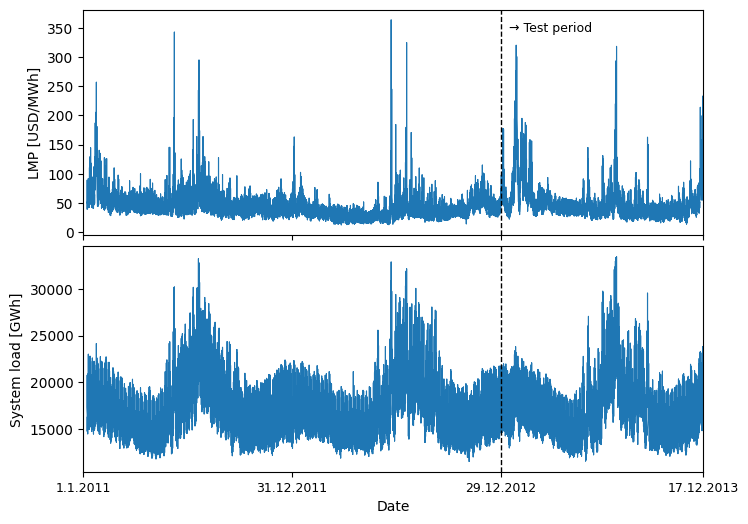

In [62]:
split_date = pd.Timestamp("2012-12-29")  # as in the article

x_ticks = [
    pd.Timestamp("2011-01-01"),
    pd.Timestamp("2011-12-31"),
    pd.Timestamp("2012-12-29"),
    pd.Timestamp("2013-12-17")
]
x_labels = ["1.1.2011", "31.12.2011", "29.12.2012", "17.12.2013"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                               gridspec_kw={'hspace': 0.05})

# Top: prices
ax1.plot(gefcom_plot["Date"], gefcom_plot["Price"], linewidth=0.8)
ax1.set_ylabel("LMP [USD/MWh]", fontsize=10)

# Bottom: system load
ax2.plot(gefcom_plot["Date"], gefcom_plot["System_load"], linewidth=0.8)
ax2.set_ylabel("System load [GWh]", fontsize=10)
ax2.set_xlabel("Date", fontsize=10)

xmin = gefcom_plot["Date"].min()
xmax = gefcom_plot["Date"].max()
ax1.set_xlim(xmin, xmax)

ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, fontsize=9)

for ax in [ax1, ax2]:
    ax.axvline(split_date, color="k", linestyle="--", linewidth=1)

ax1.text(split_date + pd.Timedelta(days=15), 350,
         "→ Test period", fontsize=9, va="center")

plt.tight_layout()
plt.show()

In [ ]:
#  Train/test split
# Train sample: all data strictly before split_date
train = gefcom[gefcom["Date"] < split_date].reset_index(drop=True)

# Test sample: from split_date onwards
test = gefcom[gefcom["Date"] >= split_date].reset_index(drop=True)


# Final set of window lengths (Win(T))
windows_length = list(range(28, 729))

hours = range(24)

# Full history arrays for calibration (train + earlier test, as in rolling window)
hours_all   = gefcom["Hour"].values
day_ids_all = gefcom["day_id"].values
X_all       = gefcom[X_cols].to_numpy(dtype=float)
y_all       = gefcom["Log_price"].to_numpy(dtype=float)

# Test arrays for forecasting and MAE
hours_test_all   = test["Hour"].values
test_day_ids_all = test["day_id"].values
test_X_all       = test[X_cols].to_numpy(dtype=float)

# True prices for MAE (on original scale)
y_true = test["Price"].to_numpy()

# Prepare per-hour data

hour_data = {}
for h in hours:
    mask_train_h = (hours_all == h)
    mask_test_h  = (hours_test_all == h)
    hour_data[h] = {
        'X': X_all[mask_train_h],
        'y': y_all[mask_train_h],
        'day_ids': day_ids_all[mask_train_h],
        'X_test': test_X_all[mask_test_h],
        'day_ids_test': test_day_ids_all[mask_test_h],
        'test_mask_global': mask_test_h,
    }


# OLS 

def fit_ols(X, y):
    X_ols = np.column_stack([np.ones((X.shape[0], 1)), X])
    beta, *_ = np.linalg.lstsq(X_ols, y)
    return beta

def predict_ols(X, beta):
    X_ols = np.column_stack([np.ones((X.shape[0], 1)), X])
    return X_ols @ beta

def run_hour_for_window(T, h):
    data = hour_data[h]
    X_h, y_h, day_h = data['X'], data['y'], data['day_ids']
    X_test_h, test_day_h = data['X_test'], data['day_ids_test']

    preds = np.full_like(test_day_h, np.nan, dtype=float)

    for d_day in np.unique(test_day_h):
        # Use last T days before d_day
        mask_cal = (day_h >= d_day - T) & (day_h < d_day)

        X_train = X_h[mask_cal]
        y_train = y_h[mask_cal]

        if X_train.shape[0] == 0:
            continue  # safety check 

        beta = fit_ols(X_train, y_train)

        mask_test_day = (test_day_h == d_day)
        X_test_day = X_test_h[mask_test_day]
        preds_day = predict_ols(X_test_day, beta)
        preds[mask_test_day] = preds_day

    return h, preds

def run_window(T):
    preds_window = np.full(len(test), np.nan, dtype=float)

    outputs = Parallel(n_jobs=-1, backend='loky')(
        delayed(run_hour_for_window)(T, h) for h in hours
    )

    for h, preds_h in outputs:
        preds_window[hour_data[h]['test_mask_global']] = preds_h

    return {'T': T, 'Predictions': preds_window}

In [ ]:
# Run ARX for all T and compute Win(T) MAE

results_ARX = [run_window(T) for T in tqdm(windows_length,
                                           desc="Window length (ARX)")]

results_mae = []
for r in results_ARX:
    T = r["T"]
    pred_log = r["Predictions"]

    mask = ~np.isnan(pred_log) & ~np.isnan(y_true)
    pred_price = np.exp(pred_log)
    mae = np.mean(np.abs(y_true[mask] - pred_price[mask]))

    results_mae.append({"T": T, "MAE": mae})

Win_T = pd.DataFrame(results_mae).sort_values("T").reset_index(drop=True)
print(Win_T.head())
print(Win_T.tail())

Window length (ARX):   0%|          | 0/701 [00:00<?, ?it/s]

Window length (ARX): 100%|██████████| 701/701 [01:58<00:00,  5.93it/s]


    T       MAE
0  28  7.422864
1  29  7.324881
2  30  7.301913
3  31  7.332054
4  32  7.314449
       T       MAE
696  724  6.992155
697  725  6.989692
698  726  6.987301
699  727  6.981222
700  728  6.970717


In [65]:
# Check how many unique calibration days are actually used for selected window sizes
def effective_days_for_T(T, h=0):
    data = hour_data[h]
    day_h = data['day_ids']

    # Grab the first test day so the window always looks back from that point
    d_day = data['day_ids_test'].min()

    mask_cal = (day_h >= d_day - T) & (day_h < d_day)
    X_train = data['X'][mask_cal]
    y_train = data['y'][mask_cal]

    valid = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    used_days = np.unique(day_h[mask_cal][valid])
    return len(used_days), used_days.min(), used_days.max()

for T in [28, 364, 721, 728]:
    n_days, d_min, d_max = effective_days_for_T(T)
    print(f"T={T}: actual days used = {n_days}, from {d_min} to {d_max}")

T=28: actual days used = 28, from 693 to 720
T=364: actual days used = 364, from 357 to 720
T=721: actual days used = 721, from 0 to 720
T=728: actual days used = 721, from 0 to 720


In [ ]:
# Define all AW sets (same as in the article)
set_defs = {
    "AW(364,728)": [364, 728],
    "AW(28,728)": [28, 728],
    "AW(56,728)": [56, 728],
    
    "AW(28:728)": list(range(28, 729, 1)),       
    "AW(28:7:728)": list(range(28, 729, 7)),    
    "AW(28:14:728)": list(range(28, 729, 14)),   
    "AW(28:28:728)": list(range(28, 729, 28)),    

    "AW(28:28:84,714:7:728)": list(range(28, 85, 28)) + list(range(714, 729, 7)),
    "AW(28,56,728)": [28, 56, 728],
    "AW(28,56,364,728)": [28, 56, 364, 728],
    "AW(28,56,721,728)": [28, 56, 721, 728],
}


pred_dict_ARX = {r["T"]: r["Predictions"] for r in results_ARX}

def compute_aw_mae(pred_dict, Tset, name, y_true):
    Ts_available = [T for T in Tset if T in pred_dict]
    if len(Ts_available) == 0:
        return None

    preds_log_list = [pred_dict[T] for T in Ts_available]
    preds_price_mat = np.vstack([np.exp(p) for p in preds_log_list])
    preds_price_avg = np.nanmean(preds_price_mat, axis=0)

    mask = ~np.isnan(preds_price_avg) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - preds_price_avg[mask]))

    return {
        "Name": name,
        "Size": len(Ts_available),
        "MAE": mae,
        "Tset": Ts_available
    }

aw_rows = []
for name, Tset in set_defs.items():
    row = compute_aw_mae(pred_dict_ARX, Tset, name, y_true)
    if row is not None:
        aw_rows.append(row)

AW = pd.DataFrame(aw_rows).sort_values("MAE").reset_index(drop=True)
AW

,Name,Size,MAE,Tset
0,"AW(28,56,721,728)",4,6.566417,"[28, 56, 721, 728]"
1,"AW(28,56,728)",3,6.583688,"[28, 56, 728]"
2,"AW(28,56,364,728)",4,6.593271,"[28, 56, 364, 728]"
3,"AW(28:28:84,714:7:728)",6,6.618265,"[28, 56, 84, 714, 721, 728]"
4,"AW(28,728)",2,6.637297,"[28, 728]"
5,"AW(56,728)",2,6.650747,"[56, 728]"
6,AW(28:28:728),26,6.887540,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280..."
7,AW(28:14:728),51,6.902236,"[28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 1..."
8,AW(28:7:728),101,6.909873,"[28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 1..."
9,AW(28:728),701,6.916385,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3..."


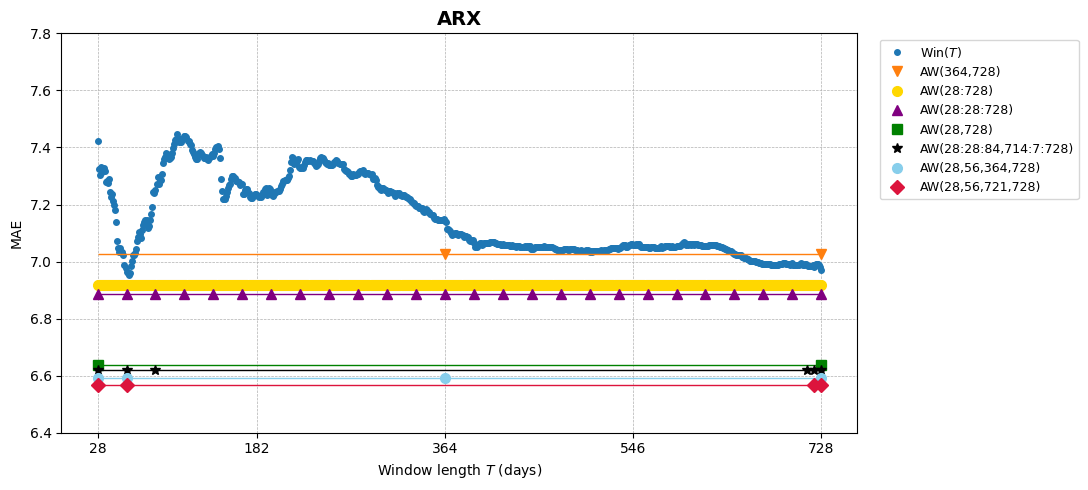

In [ ]:
plot_order = [
    (f"AW(364,728)", "v", "tab:orange"),
    (f"AW(28:728)", "o", "gold"),
    (f"AW(28:28:728)", "^", "purple"),
    (f"AW(28,728)", "s", "green"),
    (f"AW(28:28:84,714:7:728)", "*", "black"),
    (f"AW(28,56,364,728)", "o", "skyblue"),
    (f"AW(28,56,721,728)", "D", "crimson"),
]

fig, ax = plt.subplots(figsize=(11, 5))

# Win(T) points
ax.plot(
    Win_T["T"], Win_T["MAE"],
    "o", color="tab:blue", markersize=4,
    label=r"$\mathrm{Win}(T)$"
)

# AW sets
for (name, marker, color) in plot_order:
    row = AW[AW["Name"] == name]
    if row.empty:
        continue

    mae = row["MAE"].values[0]
    T_used = row["Tset"].values[0]  

    # Horizontal line across full T range
    ax.hlines(mae, xmin=28, xmax=728,
              colors=color, linestyles="-", linewidth=1)

    # Markers only at Ts actually used
    x_points = np.array(T_used, dtype=int)
    y_points = np.full_like(x_points, mae, dtype=float)
    ax.plot(x_points, y_points, marker=marker, color=color,
            linestyle="None", markersize=7, label=name)

ax.set_xlabel("Window length $T$ (days)")
ax.set_ylabel("MAE")
ax.set_ylim([6.4, 7.8])
ax.set_title("ARX", fontweight="bold", fontsize=14)
ax.set_xticks([28, 182, 364, 546, 728])
ax.grid(True, linestyle="--", linewidth=0.5)

ax.legend(fontsize=9, loc="upper left",
          bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()

In [ ]:
baseline_T = 728
baseline_mae = Win_T.loc[Win_T["T"] == baseline_T, "MAE"].values[0]

df = AW.copy()
df["Delta_log_vs_Win_maxT"] = np.log(baseline_mae / df["MAE"])
df["Pct_change_vs_Win_maxT"] = (baseline_mae / df["MAE"] - 1) * 100

rows = []
for T in [28, 364, baseline_T]:
    mae_T = Win_T.loc[Win_T["T"] == T, "MAE"].values[0]
    delta_log = np.log(baseline_mae / mae_T)
    pct_change = (baseline_mae / mae_T - 1) * 100

    rows.append({
        "Name": f"Win({T})",
        "Size": 1,
        "MAE": mae_T,
        "Tset": [T],
        "Delta_log_vs_Win_maxT": delta_log,
        "Pct_change_vs_Win_maxT": pct_change
    })

df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)

df = df.sort_values("Pct_change_vs_Win_maxT", ascending=False).reset_index(drop=True)

AW_sorted = df[["Name", "MAE", "Pct_change_vs_Win_maxT"]]
AW_sorted

,Name,MAE,Pct_change_vs_Win_maxT
0,"AW(28,56,721,728)",6.566417,6.157081
1,"AW(28,56,728)",6.583688,5.878598
2,"AW(28,56,364,728)",6.593271,5.724721
3,"AW(28:28:84,714:7:728)",6.618265,5.325445
4,"AW(28,728)",6.637297,5.023434
5,"AW(56,728)",6.650747,4.811036
6,AW(28:28:728),6.887540,1.207638
7,AW(28:14:728),6.902236,0.992161
8,AW(28:7:728),6.909873,0.880541
9,AW(28:728),6.916385,0.785549
